In [74]:
import pandas as pd
import numpy as np

from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv
import torch
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
## load the dataframe and view the first 5 rows
df = pd.read_csv('data/chess_games.csv')
df.head(1)

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

In [4]:
df.drop(['moves', 'opening_code', 'opening_fullname', 'opening_response', 'opening_variation', 'time_increment'], axis=1, inplace=True)

In [5]:
df.head()

,game_id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_moves,opening_shortname
0,1,False,13,Out of Time,White,bourgris,1500,a-00,1191,5,Slav Defense
1,2,True,16,Resign,Black,a-00,1322,skinnerua,1261,4,Nimzowitsch Defense
2,3,True,61,Mate,White,ischia,1496,a-00,1500,3,King's Pawn Game
3,4,True,61,Mate,White,daniamurashov,1439,adivanov2009,1454,3,Queen's Pawn Game
4,5,True,95,Mate,White,nik221107,1523,adivanov2009,1469,5,Philidor Defense


In [6]:
## encode the categorical features
rated_enc = LabelEncoder()
victory_status_enc = LabelEncoder()
winner_enc = LabelEncoder()
opening_shortname_enc = LabelEncoder()

In [7]:
df_enc = df.copy()

In [8]:
df_enc['rated'] = rated_enc.fit_transform(df['rated'])
df_enc['victory_status'] = victory_status_enc.fit_transform(df['victory_status'])
df_enc['winner'] = winner_enc.fit_transform(df['winner'])
df_enc['opening_shortname'] = opening_shortname_enc.fit_transform(df['opening_shortname'])

In [9]:
df_enc.head()

,game_id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_moves,opening_shortname
0,1,0,13,2,2,bourgris,1500,a-00,1191,5,110
1,2,1,16,3,0,a-00,1322,skinnerua,1261,4,74
2,3,1,61,1,2,ischia,1496,a-00,1500,3,61
3,4,1,61,1,2,daniamurashov,1439,adivanov2009,1454,3,94
4,5,1,95,1,2,nik221107,1523,adivanov2009,1469,5,83


In [10]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  int64 
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  int32 
 4   winner             20058 non-null  int32 
 5   white_id           20058 non-null  object
 6   white_rating       20058 non-null  int64 
 7   black_id           20058 non-null  object
 8   black_rating       20058 non-null  int64 
 9   opening_moves      20058 non-null  int64 
 10  opening_shortname  20058 non-null  int32 
dtypes: int32(3), int64(6), object(2)
memory usage: 1.5+ MB


In [11]:
winner_enc.classes_


array(['Black', 'Draw', 'White'], dtype=object)

For visualization puposes we will first make a small graph of the first 100 nodes (rows)

In [12]:
sub_df = df.iloc[:100,:]

In [13]:
##get the games where a specific player has participated
sub_df.loc[(sub_df["white_id"] == "naster1") | (sub_df["black_id"] == "naster1")]

,game_id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_moves,opening_shortname


## Build the graph

In [14]:
## Undirected graph
chess_graph = nx.Graph()

In [15]:
df.iloc[0]['rated']

False

In [16]:
## Create the nodes
chess_graph.add_nodes_from([(sub_df.iloc[i]['game_id'], {
    "rated":sub_df.iloc[i]['rated'],
    "turns":sub_df.iloc[i]['turns'],
    "victory_status":sub_df.iloc[i]['victory_status'],
    "white_rating":sub_df.iloc[i]['white_rating'],
    "black_rating":sub_df.iloc[i]['black_rating'],
    "opening_moves":sub_df.iloc[i]['opening_moves'],
    "opening_shortname":sub_df.iloc[i]['opening_shortname'],
    "winner":sub_df.iloc[i]['winner'],
}) for i in range(sub_df.shape[0])])

In [17]:
chess_graph.nodes[4]

{'rated': True,
 'turns': 61,
 'victory_status': 'Mate',
 'white_rating': 1439,
 'black_rating': 1454,
 'opening_moves': 3,
 'opening_shortname': "Queen's Pawn Game",
 'winner': 'White'}

In [18]:
def generate_edges(player_name):
    list_games = sub_df.loc[(sub_df["white_id"] == player_name) | (sub_df["black_id"] == player_name), "game_id"].to_list()
    n = len(list_games)

    i = 0
    edges = []
    while i < n-1:
        for game_id in list_games[i+1:]:
            edges.append((list_games[i], game_id))

        i += 1

    return edges

In [19]:
## get the players names
names = sub_df["white_id"].unique().tolist()
names.extend(sub_df["black_id"].unique().tolist())
names = pd.Series(names).unique()

In [20]:
## Make the edges
for name in names:
    chess_graph.add_edges_from(generate_edges(name))

In [22]:
##Lets draw the graph. It will take a wile since its a big one with more than 20k nodes
val_map = {'White': 0.7,
           'Black': 0.0,
           'Draw': 0.571428}
values = [val_map.get(chess_graph.nodes[node]["winner"], 0.25) for node in chess_graph.nodes()]
plt.figure(figsize=(200,200))
nx.draw(chess_graph, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')
plt.show()

In [22]:
## Let's observe some of the neoghbors of node 84
[n for n in chess_graph.neighbors(84)]

[61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97]

In [30]:
## Select these game from the dataset to have a more relational analysis
df.loc[df["game_id"].isin([84, 96, 61, 75, 68])]

,game_id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_moves,opening_shortname
60,61,True,37,Resign,Black,iskendermyucel,1207,oldpaths,1579,3,French Defense
67,68,True,78,Resign,Black,berejokserg,1500,oldpaths,1554,3,French Defense
74,75,True,37,Resign,White,redar1,1855,oldpaths,1599,5,French Defense
83,84,True,58,Mate,Black,allahdeweswin,1251,oldpaths,1545,3,Crab Opening
95,96,True,85,Mate,White,oldpaths,1513,remisero,1784,2,Horwitz Defense


Now we will build the full graph of 20k nodes.

In [40]:
## Undirected graph
chess_graph = nx.Graph()

In [41]:
df.iloc[0]['rated']

False

In [42]:
## Create the nodes
chess_graph.add_nodes_from([(df_enc.iloc[i]['game_id'], {
    "x":[df_enc.iloc[i]['rated'], df_enc.iloc[i]['turns'], df_enc.iloc[i]['victory_status'], df_enc.iloc[i]['white_rating'], df_enc.iloc[i]['black_rating'], df_enc.iloc[i]['opening_moves'], df_enc.iloc[i]['opening_shortname']],
    "y":df_enc.iloc[i]['winner'],
}) for i in range(df_enc.shape[0])])

In [43]:
chess_graph.nodes[4]

{'x': [1, 61, 1, 1439, 1454, 3, 94], 'y': 2}

In [44]:
def generate_edges(player_name):
    list_games = sub_df.loc[(df_enc["white_id"] == player_name) | (df_enc["black_id"] == player_name), "game_id"].to_list()
    n = len(list_games)

    i = 0
    edges = []
    while i < n-1:
        for game_id in list_games[i+1:]:
            edges.append((list_games[i], game_id))

        i += 1

    return edges

In [45]:
## get the players names
names = df_enc["white_id"].unique().tolist()
names.extend(df_enc["black_id"].unique().tolist())
names = pd.Series(names).unique()

In [46]:
## Make the edges
for name in names:
    chess_graph.add_edges_from(generate_edges(name))

<Axes: >

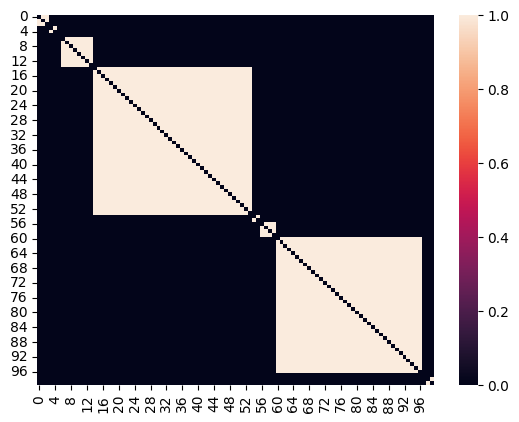

In [28]:
## Lets look at the adjacency matrix
sns.heatmap(nx.adjacency_matrix(chess_graph).todense()[:100, :100])

## Build Pytorch Geometric graph

In [29]:
d = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
##We can generate the graph automatically from networkx into pytorch geometric using the "from_networkx" function
pyg_chess_graph = from_networkx(chess_graph)
pyg_chess_graph.to(d)

Data(x=[20058, 7], edge_index=[2, 2972], y=[20058])

In [48]:
pyg_chess_graph.x

tensor([[   0,   13,    2,  ..., 1191,    5,  110],
        [   1,   16,    3,  ..., 1261,    4,   74],
        [   1,   61,    1,  ..., 1500,    3,   61],
        ...,
        [   1,   35,    1,  ..., 1286,    3,   94],
        [   1,  109,    3,  ..., 1227,    4,   84],
        [   1,   78,    1,  ..., 1339,    3,   94]], device='cuda:0')

In [49]:
##Sample by nodes
transform = RandomNodeSplit(num_val=0.1, num_test=0.2)
transformed_graph = transform(pyg_chess_graph).to(d)

In [101]:
class GCN_model(torch.nn.Module):
    def __init__(self, input_features, out_classe):
        super().__init__()
        torch.manual_seed(123)
        self.conv1 = GCNConv(input_features, 5)
        self.conv2 = GCNConv(5, 4)
        self.conv3 = GCNConv(4, 3)
        self.fc1 = torch.nn.Linear(3,out_classe)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.nn.functional.relu(x)

        x = self.fc1(x)

        return x

In [102]:
model = GCN_model(transformed_graph.num_features, 3).to(d)

In [103]:
pyg_chess_graph.x[transformed_graph.train_mask]

tensor([[   0,   13,    2,  ..., 1191,    5,  110],
        [   1,   16,    3,  ..., 1261,    4,   74],
        [   1,   61,    1,  ..., 1500,    3,   61],
        ...,
        [   1,   82,    1,  ..., 1196,    2,   93],
        [   1,   35,    1,  ..., 1286,    3,   94],
        [   1,  109,    3,  ..., 1227,    4,   84]], device='cuda:0')

In [104]:
model(pyg_chess_graph.x[transformed_graph.train_mask].float(), pyg_chess_graph.edge_index)

tensor([[-184.4021,   27.2201,  -86.4034],
        [-184.4021,   27.2201,  -86.4034],
        [-184.4021,   27.2201,  -86.4034],
        ...,
        [-165.3215,   24.4211,  -77.5165],
        [-167.0175,   24.6699,  -78.3064],
        [-181.4616,   26.7888,  -85.0339]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [105]:
pyg_chess_graph.y

tensor([2, 0, 2,  ..., 2, 2, 0], device='cuda:0', dtype=torch.int32)

In [106]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

sc = StandardScaler()
transformed_graph.x = torch.tensor(sc.fit_transform(transformed_graph.x.cpu())).to(d)

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      x = sc.fit_transform(transformed_graph.x.cpu())
      out = model(transformed_graph.x.float(), transformed_graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[transformed_graph.train_mask], transformed_graph.y[transformed_graph.train_mask].type(torch.LongTensor).to(d))  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(transformed_graph.x.float(), transformed_graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[transformed_graph.test_mask] == transformed_graph.y[transformed_graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(transformed_graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 1000):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.2196
Epoch: 002, Loss: 1.1965
Epoch: 003, Loss: 1.1769
Epoch: 004, Loss: 1.1602
Epoch: 005, Loss: 1.1459
Epoch: 006, Loss: 1.1334
Epoch: 007, Loss: 1.1221
Epoch: 008, Loss: 1.1115
Epoch: 009, Loss: 1.1014
Epoch: 010, Loss: 1.0916
Epoch: 011, Loss: 1.0818
Epoch: 012, Loss: 1.0720
Epoch: 013, Loss: 1.0619
Epoch: 014, Loss: 1.0515
Epoch: 015, Loss: 1.0408
Epoch: 016, Loss: 1.0297
Epoch: 017, Loss: 1.0183
Epoch: 018, Loss: 1.0068
Epoch: 019, Loss: 0.9953
Epoch: 020, Loss: 0.9839
Epoch: 021, Loss: 0.9728
Epoch: 022, Loss: 0.9622
Epoch: 023, Loss: 0.9522
Epoch: 024, Loss: 0.9430
Epoch: 025, Loss: 0.9346
Epoch: 026, Loss: 0.9271
Epoch: 027, Loss: 0.9203
Epoch: 028, Loss: 0.9142
Epoch: 029, Loss: 0.9084
Epoch: 030, Loss: 0.9027
Epoch: 031, Loss: 0.8971
Epoch: 032, Loss: 0.8915
Epoch: 033, Loss: 0.8860
Epoch: 034, Loss: 0.8805
Epoch: 035, Loss: 0.8754
Epoch: 036, Loss: 0.8707
Epoch: 037, Loss: 0.8665
Epoch: 038, Loss: 0.8627
Epoch: 039, Loss: 0.8595
Epoch: 040, Loss: 0.8566


In [107]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6685
